In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import collections
%matplotlib inline
from tabulate import tabulate

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

pdtabulate=lambda df:tabulate(df,headers='keys',tablefmt='psql')

In [3]:
df = pd.read_csv('data/u.item',encoding='latin-1',sep='|',header=None,names=['movie_id','movie_title','release_date','video_release_date','IMDb URL','unknown','action','adventure','animation','children\'s','comedy','crime','documentary','drama','fantasy','film-noir','horror','musical','mystery','romance','sci-fi','thriller','war','western'])
id_to_title = dict(zip(df.movie_id,df.movie_title))
df.head()

,movie_id,movie_title,release_date,video_release_date,IMDb URL,unknown,action,adventure,animation,children's,...,fantasy,film-noir,horror,musical,mystery,romance,sci-fi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [4]:
df = pd.read_csv('data/u.data',sep='\t',header=None,names=['user_id','movie_id','rating','timestamp'])
df = df.drop('timestamp', axis=1)
print('rating values:',np.unique(df.rating))
# df = pd.merge(df_aux, df)
# del df_aux
movies_number_reviews = df[['rating','movie_id']].groupby('movie_id').count()
list_above = movies_number_reviews[movies_number_reviews.rating > 25].index
df = df[df['movie_id'].isin(list_above)]

df

rating values: [1 2 3 4 5]


,user_id,movie_id,rating
0,196,242,3
1,186,302,3
3,244,51,2
4,166,346,1
5,298,474,4
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [5]:
def load_data(dataset='100k'):
    if dataset=='100k' or dataset==0:
        df = pd.read_csv('data/ml-100k/u.item',encoding='latin-1',sep='|',header=None,names=['movie_id','movie_title','release_date','video_release_date','IMDb URL','unknown','action','adventure','animation','children\'s','comedy','crime','documentary','drama','fantasy','film-noir','horror','musical','mystery','romance','sci-fi','thriller','war','western'])
        id_to_title = dict(zip(df.movie_id,df.movie_title))
        df = pd.read_csv('data/u.data',sep='\t',header=None,names=['user_id','movie_id','rating','timestamp'])
    if dataset=='1M' or dataset==1:
        df = pd.read_csv('data/ml-1m/movies.dat',encoding='latin-1',sep='::',header=None, names=['movie_id','movie_title','trash'])
        id_to_title = dict(zip(df.movie_id,df.movie_title))
        df = pd.read_csv('data/ml-1m/ratings.dat', header=None, sep='::', names=['user_id','movie_id','rating','timestamp'])
            
    df = df.drop('timestamp', axis=1)
    print('rating values:',np.unique(df.rating))
    print('Initial number of films:', len(np.unique(df.movie_id)))
    print('Initial number of users:',len(np.unique(df.user_id)))
    movie_hist = df.groupby('movie_id').count().rating
    user_hist = df.groupby('user_id').count().rating
    df = df[ df.movie_id.isin( movie_hist[movie_hist >20].index ) ]
    df = df[ df.user_id.isin( user_hist[user_hist >20].index ) ]
    return df, id_to_title

In [6]:
def split_df(df, train_ratio=0.9):
    user_list = np.unique(df.user_id)
    train =  pd.DataFrame({'user_id': [], 'movie_id':[], 'rating':[]}).astype('int32')
    test = pd.DataFrame({'user_id': [], 'movie_id':[], 'rating':[]}).astype('int32')
    train_list = []
    test_list = []
    for user_id in user_list:
        df_reduced = df[df.user_id==user_id]
        mask = np.random.rand(len(df_reduced)) < train_ratio
        train_list.append(df_reduced[mask])
        test_list.append(df_reduced[~mask])
    train = pd.concat(train_list)
    test = pd.concat(test_list) 
    return train, test


In [2]:
from sklearn.metrics import pairwise_distances
from time import time as tt
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity


def custom(metric='euclidean', min_common_items=2):
    
    def cosine_sim(u,v):
        mask = (u>0)&(v>0)
        u = u[mask]
        v = v[mask]
        if mask.sum()< min_common_items:
            return 0
        return 1-cosine(u,v)
        
    def cosine_adjusted_sim(u,v):
        mask = (u>0)&(v>0)
        u = u[mask]
        v = v[mask]
        if mask.sum()< min_common_items:
            return 0
        return 1 - cosine(u, v)
        

    # Returns a distance-based similarity score for person1 and person2
    def euclid_sim(u,v):
        mask = (u>0)&(v>0)
        u = u[mask]
        v = v[mask]
        if mask.sum() < min_common_items:
            return 0
        #return distEuclid(rep['rating_x'],rep['rating_y']) 
        return 1.0/(1+euclidean(u,v))

    # Returns a pearsonCorrealation-based similarity score for person1 and person2
    def pearson_sim(u,v):
        mask = (u>0)&(v>0)
        u = u[mask]
        v = v[mask]
        if mask.sum() < min_common_items:
            return 0    
        res=pearsonr(u,v)[0]
        if(np.isnan(res)):
            return 0
        return res
    
    if metric=='euclidean':
        return euclid_sim
    if metric=='cosine':
        return cosine_sim
    if metric=='cosine2':
        return cosine_adjusted_sim
    if metric=='pearson':
        return pearson_sim

a = np.array([1,2,3,4,5,-1])
b = np.array([5,4,3,2,-1,5])
metric_list = ['euclidean', 'cosine', 'cosine2', 'pearson']
f = custom('cosine')

for metric in metric_list:
    print(metric, custom(metric=metric)(a,b))

euclidean 0.16952084719853724
cosine 0.7453559924999299
cosine2 0.7453559924999299
pearson -1.0


In [23]:
from sklearn.metrics import pairwise_distances
from time import time as tt
from scipy.spatial.distance import euclidean, cosine
from scipy.stats import pearsonr


class CollaborativeFiltering:
#     def __init__(self,metric='euclidean',min_common_users=2):
    def __init__(self):
        self.sim_mat=None
        self.movie_list = np.array([])
        self.user_list = np.array([])
        self.ratings_mat = None
        return None
    
    def split_df(self,df, train_ratio=0.9):
        user_list = np.unique(df.user_id)
        train =  pd.DataFrame({'user_id': [], 'movie_id':[], 'rating':[]}).astype('int32')
        test = pd.DataFrame({'user_id': [], 'movie_id':[], 'rating':[]}).astype('int32')
        train_list = []
        test_list = []
        for user_id in user_list:
            df_reduced = df[df.user_id==user_id]
            mask = np.random.rand(len(df_reduced)) < train_ratio
            train_list.append(df_reduced[mask])
            test_list.append(df_reduced[~mask])
        train = pd.concat(train_list)
        test = pd.concat(test_list) 
        return train, test

    
    def fit(self, df, metric='euclidean', min_common_items=2):
        self.ratings_mat = df.pivot_table(index=['user_id'],columns=['movie_id'],values='rating')
        self.movie_list = np.unique(df.movie_id)
        self.user_list = np.unique(df.user_id)
        if metric == 'cosine2':
            self.ratings_mat = self.ratings_mat.sub(self.ratings_mat.mean(axis=1), axis=0)
        self.ratings_mat.fillna( 0, inplace = True )
        
        movie_similarity = pairwise_distances( self.ratings_mat.values.T, metric=custom(metric, min_common_items) )
        np.fill_diagonal( movie_similarity, 0 )
        self.sim_mat = pd.DataFrame( data= movie_similarity, index=self.movie_list, columns=self.movie_list )
        return None
        
    def predict(self, df_pivot, user_id, movie_id):
        df_pivot = df_pivot.T
        df_reduced = df_pivot[user_id][~df_pivot[user_id].isnull()]
        user_movie_list = np.intersect1d(np.unique( df_reduced.index ),self.movie_list)
        num=0.
        den=0.
        vector1 = self.sim_mat[movie_id].filter(items=user_movie_list, axis=0)
        vector2 = df_reduced.values
        if vector1.shape != vector2.shape:
            print('WARNING WARNING')
            print('user:',user_id, 'movie:',movie_id)
            return 0 
            
        num = (self.sim_mat[movie_id].filter(items=user_movie_list, axis=0) * df_reduced.values).sum()
        den = ( np.abs(self.sim_mat[movie_id].filter(items=user_movie_list, axis=0) )).sum()
        if den==0 or num/den>6:
            movie_mean_rating = df.rating[df.movie_id == movie_id].mean()
            if movie_mean_rating >0:
                # return the mean movie rating if there is no similar for the computation
                return int(round(movie_mean_rating))
            else:
                # else return mean user rating 
                return int(round(user_mean_rating))
        return int(round(num/den))

    def evaluate(self, df):
        print('before:',df.shape)
        df = df[df.movie_id.isin(self.movie_list)]
        print('after:',df.shape)
        df_pivot = df.pivot_table(index='user_id',columns='movie_id',values='rating')
        ids_to_estimate = zip(df.user_id, df.movie_id)
        print('11')
        estimated = [self.predict(df_pivot, user, movie) if user in self.user_list else 3 for user, movie in ids_to_estimate]
        print('22')
        real = df.rating.values
        print(len(estimated), real.shape)
        rmse_2 = self.rmse_vec(estimated, real)
        mae_2 = self.mae_vec(estimated, real)
        return  rmse_2, mae_2
    
    
    def rmse_vec(self, y_pred, y_real):
        return np.sqrt(np.mean(np.power(y_pred - y_real, 2)))
    
    def mae_vec(self, y_pred, y_real):
        return np.mean(np.abs(y_pred-y_real))

    


### SOME CALCULATIONS

In [21]:
df,_ = load_data(0)
train, test = split_df(df, train_ratio=0.9)
cf = CollaborativeFiltering()
cf.fit(train)
# cf.predict(test.pivot_table(index='user_id',columns='movie_id',values='rating'),6,3)
cf.evaluate(test)

rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
before: (37822, 3)
after: (37822, 3)
11
22
37822 (37822,)


In [29]:
metric_list = ['euclidean', 'cosine', 'cosine2', 'pearson']


df,_ = load_data(0)
train, test = split_df(df, train_ratio=0.9)
cf = CollaborativeFiltering()
cf.fit(train)

rmse_list = []
mae_list = []
for metric in metric_list:
    cf = CollaborativeFiltering()
    cf.fit(train,metric)
    rmse, mae = cf.evaluate(test)
    rmse_list.append(rmse)
    mae_list.append(mae)
    
results = pd.DataFrame({'metric': metric_list, 'RMSE': rmse_list, 'MAE': mae_list})
results

rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
before: (9372, 3)
after: (9372, 3)
11
22
9372 (9372,)
before: (9372, 3)
after: (9372, 3)
11
22
9372 (9372,)
before: (9372, 3)
after: (9372, 3)
11
22
9372 (9372,)


C:\Users\Alfons\Anaconda3\lib\site-packages\scipy\stats\stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


before: (9372, 3)
after: (9372, 3)
11
22
9372 (9372,)


,metric,RMSE,MAE
0,euclidean,1.134283,0.841229
1,cosine,1.133060,0.838028
2,cosine2,1.140335,0.837495
3,pearson,1.961728,1.487303


(2,)


array([0.175, 1.175, 2.175, 3.175])

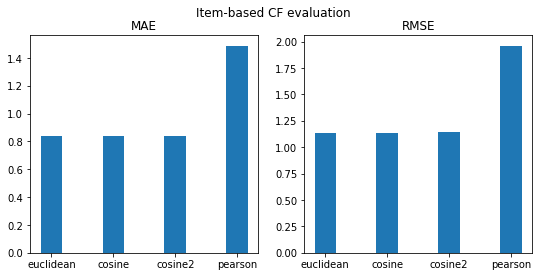

In [30]:
width = 0.35
x = np.arange(len(results.metric)) + width/2
fig,ax = plt.subplots(1,2, figsize=(9,4))
print(ax.shape)
fig.suptitle('Item-based CF evaluation')
ax[0].set_title('MAE')
ax[0].bar(x, results.MAE, width)
ax[0].set_xticks(x)
ax[0].set_xticklabels(results.metric)
ax[1].set_title('RMSE')
ax[1].bar(x, results.RMSE, width)
ax[1].set_xticks(x)
ax[1].set_xticklabels(results.metric)
# plt.show()
x

In [24]:
from time import time

train_ratio = np.linspace(0.2,0.8, 4)


rmse_list = []
mae_list = []
train_size_list=[]
test_size_list=[]
train_time_list = []
test_time_list = []
total_time_list = []

for ratio in train_ratio:
    print('ratio:', ratio, end=' ')
    df,_ = load_data(0)
    train, test = split_df(df, train_ratio=ratio)
    cf = CollaborativeFiltering()
    train_time = time()
    cf.fit(train,metric='euclidean')
    train_time = time() - train_time
    test_time = time()
    rmse, mae = cf.evaluate(test)
    test_time = time() - test_time
    train_size_list.append(len(train))
    test_size_list.append(len(test))
    rmse_list.append(rmse)
    mae_list.append(mae)
    train_time_list.append(train_time)
    test_time_list.append(test_time)
    total_time_list.append(train_time+test_time)
    print('Time:', train_time+test_time)
    
results_x = pd.DataFrame({'Train ratio': train_ratio, 'Train size': train_size_list, 'Test size': test_size_list,  'Train time': train_time_list, 'Test time': test_time_list, 'Total time': total_time_list,'RMSE': rmse_list, 'MAE': mae_list})


ratio: 0.2 rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
before: (75259, 3)
after: (75259, 3)
11
22
75259 (75259,)
Time: 289.43187403678894
ratio: 0.4 rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
before: (56342, 3)
after: (56342, 3)
11
22
56342 (56342,)
Time: 238.79507660865784
ratio: 0.6000000000000001 rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
before: (37614, 3)
after: (37614, 3)
11
22
37614 (37614,)
Time: 158.47384905815125
ratio: 0.8 rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
before: (18637, 3)
after: (18637, 3)
11
22
18637 (18637,)
Time: 92.12835192680359


NameError: name 'results' is not defined

In [25]:
results_x

,Train ratio,Train size,Test size,Train time,Test time,Total time,RMSE,MAE
0,0.2,18854,75259,12.472125,276.959749,289.431874,1.072078,0.784610
1,0.4,37771,56342,16.242323,222.552754,238.795077,1.073412,0.792588
2,0.6,56499,37614,18.655797,139.818052,158.473849,1.076339,0.795874
3,0.8,75476,18637,19.842127,72.286225,92.128352,1.095386,0.812041


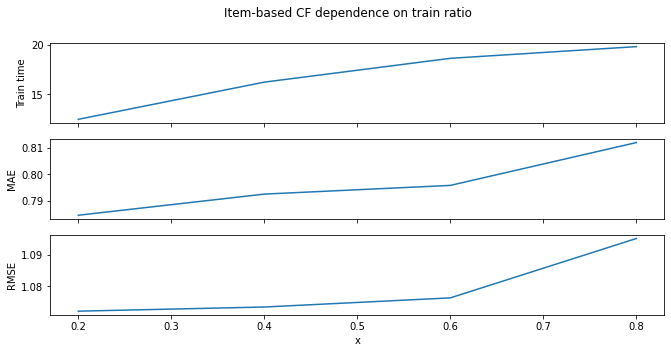

In [28]:
fig,ax = plt.subplots(3,1, figsize=(11,5), sharex=True)
fig.suptitle('Item-based CF dependence on train ratio')

ax[0].plot(results_x['Train ratio'], results_x['Train time'])
ax[0].set_ylabel('Train time')

ax[1].plot(results_x['Train ratio'], results_x['MAE'])
ax[1].set_ylabel('MAE')

ax[2].plot(results_x['Train ratio'], results_x['RMSE'])
ax[2].set_xlabel('x')
ax[2].set_ylabel('RMSE')

plt.show()

In [38]:
from time import time
ratio_list =np.linspace(0.1,0.9,9)

ns = []
times = []
for ratio in ratio_list:
    df,_ = load_data(0)
    train,_ = split_df(df, train_ratio=ratio)
    n = len(train)
    ns.append(n)
    cf = CollaborativeFiltering()
    t = time()
    cf.fit(train)
    t = time() - t
    times.append(t)
    
result_n = pd.DataFrame({'N': ns, 'Time': times})
result_n

rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943
rating values: [1 2 3 4 5]
Initial number of films: 1682
Initial number of users: 943


,N,Time
0,9528,9.888890
1,19241,11.936390
2,28136,13.672720
3,37654,15.286798
4,47022,16.571463
5,56356,17.567304
6,66204,18.115246
7,75355,18.613365
8,84584,19.071363


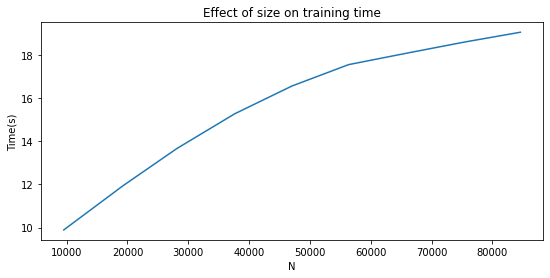

In [50]:
fig, ax = plt.subplots(figsize=(9,4))
ax.set_title('Effect of size on training time')
ax.set_xlabel('N')
ax.set_ylabel('Time(s)')
ax.plot(result_n.N,result_n.Time )